Workflow to combine all dataframes



In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

## Combine burn indices, host species and recovery

In [2]:
# read in each independant dataframe

# no history 
no_bi = pd.read_csv("../data/outputs/no_history/on_no_history_burn_indices.csv")
no_host = pd.read_csv("../data/outputs/no_history/on_no_history_host_species_percentage.csv")
no_recovery = pd.read_csv("../data/outputs/no_history/on_no_history_recovery_magnitude.csv")

# history
defol_bi = pd.read_csv("../data/outputs/on/on_burn_indices.csv")
defol_host = pd.read_csv("../data/outputs/on/on_host_species_percentage.csv")
defol_recovery = pd.read_csv("../data/outputs/on/on_recovery_magnitude/on_recovery_magnitude.csv")

Filter out all fires in no history that have a year greater than 2012

In [17]:
# Remove rows where Fire_Year is greater than 2012
# Extract the year from the Fire_ID column and add it as a new column
no_bi['year'] = no_bi['Fire_ID'].apply(lambda x: int(x.split('_')[1]))
no_recovery['year'] = no_recovery['Fire_ID'].apply(lambda x: int(x.split('_')[1]))

# Filter the DataFrame to remove all rows where the year is greater than 2012
no_bi = no_bi[no_bi['year'] <= 2012]
no_recovery = no_recovery[no_recovery['year'] <= 2012]
# Drop the year column
no_bi = no_bi.drop(columns=['year'])
no_recovery = no_recovery.drop(columns=['year'])


Check for columns that match between all dataframes

In [18]:
dataframes = [no_bi, no_host, no_recovery, defol_bi, defol_host, defol_recovery]

# Get the set of columns for each dataframe
columns_sets = [set(df.columns) for df in dataframes]

# Find the intersection of all column sets to get the matching columns
matching_columns = set.intersection(*columns_sets)

# Print the matching columns
print("Matching columns in all CSV files:", matching_columns)

Matching columns in all CSV files: {'Fire_ID'}


Combine the the no history and history dataframes

In [19]:
# Combine all defoliation dataframes by 'Fire_ID'
combined_defol = pd.concat([defol_bi, defol_host, defol_recovery]).groupby('Fire_ID').sum().reset_index().drop(columns=['Unnamed: 0'])
# Add 'history' column to combined_defol_df with value 1
combined_defol['history'] = 1
# Move 'history' column to the second position in combined_defol_df
cols = combined_defol.columns.tolist()
cols.insert(1, cols.pop(cols.index('history')))
combined_defol = combined_defol[cols]


# Combine all non-defoliation dataframes by 'Fire_ID'
combined_no = pd.concat([no_bi, no_host, no_recovery]).groupby('Fire_ID').sum().reset_index().drop(columns=['Unnamed: 0'])
# Add 'history' column to combined_no_df with value 0
combined_no['history'] = 0
# Move 'history' column to the second position in combined_no_df
cols = combined_no.columns.tolist()
cols.insert(1, cols.pop(cols.index('history')))
combined_no = combined_no[cols]

## convert fire_year in in both dataframes to int64
combined_no['Fire_Year'] = combined_no['Fire_Year'].astype('int64')
combined_defol['Fire_Year'] = combined_defol['Fire_Year'].astype('int64')


view dataframes

In [20]:
combined_no.head()

,Fire_ID,history,rbr,rbr_w_offset,Fire_Year,host_species,total_pixels,host_percentage,Average Recovery
0,COC12_2002_53,0,533.86,307.24,2002,171.0,171.0,100.0,80.84
1,COC14_2009_1703,0,530.39,328.14,2009,3942.0,3942.0,100.0,86.67
2,COC15_1987_935,0,619.05,300.35,1987,2759.0,2759.0,100.0,67.41
3,COC16_1992_1239,0,474.17,274.28,1992,45919.0,45920.0,100.0,90.05
4,COC16_2009_1720,0,546.34,337.31,2009,647.0,647.0,100.0,87.23


Add column to defol dataframe that shows the max overlap and other overlap statistics

In [21]:
occurrence = pd.read_csv("../data/outputs/on/on_co-occurrence_defoliation_history.csv")

# print occurence columns
print(occurrence.columns)

print(occurrence.info())
print(combined_defol.info())


# Merge the combined no history dataframe with occurence based on 'Fire_ID'
combined_defol = pd.merge(combined_defol, occurrence, on=['Fire_ID', 'Fire_Year'])

Index(['Fire_ID', 'Fire_Year', 'Time_Since_Defoliation', 'Cumulative_Years',
       'Max_Overlap_Area', 'Max_Overlap_Percent'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Fire_ID                 365 non-null    object 
 1   Fire_Year               365 non-null    int64  
 2   Time_Since_Defoliation  365 non-null    int64  
 3   Cumulative_Years        365 non-null    int64  
 4   Max_Overlap_Area        365 non-null    float64
 5   Max_Overlap_Percent     365 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 17.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fire_ID           365 non-null    object 
 1   hist

inspect dataframe

In [22]:
combined_defol.head()

,Fire_ID,history,rbr,rbr_w_offset,Fire_Year,host_species,total_pixels,host_percentage,Average Recovery,Time_Since_Defoliation,Cumulative_Years,Max_Overlap_Area,Max_Overlap_Percent
0,ATI10_1987_819,1,551.66,447.91,1987,2442.0,2769.0,88.2,85.94,0,7,4.714938e+06,100.0
1,BAN1_2002_105,1,660.87,250.34,2002,127.0,934.0,13.6,96.17,14,10,2.805804e+06,100.0
2,CHA10_2010_1589,1,562.55,532.81,2010,279.0,364.0,76.6,104.52,22,16,7.649734e+05,100.0
3,CHA12_1987_1210,1,577.39,423.14,1987,40836.0,66097.0,61.8,110.75,0,16,1.530347e+08,100.0
4,CHA12_1991_532,1,616.23,478.34,1991,2261.0,6568.0,34.4,111.11,3,16,1.443114e+07,100.0


Check to see the smallest value in occurence dataframe columns

In [23]:
# smallest value in occurrence dataframe columns
print(occurrence.min())

Fire_ID                   ATI10_1987_819
Fire_Year                           1986
Time_Since_Defoliation                 0
Cumulative_Years                       1
Max_Overlap_Area            32329.555328
Max_Overlap_Percent              5.69277
dtype: object


Add columns in occurence as 0 columns in combined_no

In [24]:
combined_no.head()

,Fire_ID,history,rbr,rbr_w_offset,Fire_Year,host_species,total_pixels,host_percentage,Average Recovery
0,COC12_2002_53,0,533.86,307.24,2002,171.0,171.0,100.0,80.84
1,COC14_2009_1703,0,530.39,328.14,2009,3942.0,3942.0,100.0,86.67
2,COC15_1987_935,0,619.05,300.35,1987,2759.0,2759.0,100.0,67.41
3,COC16_1992_1239,0,474.17,274.28,1992,45919.0,45920.0,100.0,90.05
4,COC16_2009_1720,0,546.34,337.31,2009,647.0,647.0,100.0,87.23


In [25]:
# Get the column names from occurrence excluding 'Fire_ID' and 'Fire_Year'
additional_columns = [col for col in occurrence.columns if col not in ['Fire_ID', 'Fire_Year']]

# Add these columns to combined_no_df with all values set to 0
for col in additional_columns:
    combined_no[col] = 0


Inpect no history

In [26]:
combined_no.head()

,Fire_ID,history,rbr,rbr_w_offset,Fire_Year,host_species,total_pixels,host_percentage,Average Recovery,Time_Since_Defoliation,Cumulative_Years,Max_Overlap_Area,Max_Overlap_Percent
0,COC12_2002_53,0,533.86,307.24,2002,171.0,171.0,100.0,80.84,0,0,0,0
1,COC14_2009_1703,0,530.39,328.14,2009,3942.0,3942.0,100.0,86.67,0,0,0,0
2,COC15_1987_935,0,619.05,300.35,1987,2759.0,2759.0,100.0,67.41,0,0,0,0
3,COC16_1992_1239,0,474.17,274.28,1992,45919.0,45920.0,100.0,90.05,0,0,0,0
4,COC16_2009_1720,0,546.34,337.31,2009,647.0,647.0,100.0,87.23,0,0,0,0


Merge both dataframes

In [27]:
# Row-bind the two DataFrames
combined_df = pd.concat([combined_defol, combined_no], ignore_index=True)


Inspect df

In [28]:
combined_df.head()


,Fire_ID,history,rbr,rbr_w_offset,Fire_Year,host_species,total_pixels,host_percentage,Average Recovery,Time_Since_Defoliation,Cumulative_Years,Max_Overlap_Area,Max_Overlap_Percent
0,ATI10_1987_819,1,551.66,447.91,1987,2442.0,2769.0,88.2,85.94,0,7,4.714938e+06,100.0
1,BAN1_2002_105,1,660.87,250.34,2002,127.0,934.0,13.6,96.17,14,10,2.805804e+06,100.0
2,CHA10_2010_1589,1,562.55,532.81,2010,279.0,364.0,76.6,104.52,22,16,7.649734e+05,100.0
3,CHA12_1987_1210,1,577.39,423.14,1987,40836.0,66097.0,61.8,110.75,0,16,1.530347e+08,100.0
4,CHA12_1991_532,1,616.23,478.34,1991,2261.0,6568.0,34.4,111.11,3,16,1.443114e+07,100.0


In [29]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1304 entries, 0 to 1303
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Fire_ID                 1304 non-null   object 
 1   history                 1304 non-null   int64  
 2   rbr                     1304 non-null   float64
 3   rbr_w_offset            1304 non-null   float64
 4   Fire_Year               1304 non-null   int64  
 5   host_species            1304 non-null   float64
 6   total_pixels            1304 non-null   float64
 7   host_percentage         1304 non-null   float64
 8   Average Recovery        1304 non-null   float64
 9   Time_Since_Defoliation  1304 non-null   int64  
 10  Cumulative_Years        1304 non-null   int64  
 11  Max_Overlap_Area        1304 non-null   float64
 12  Max_Overlap_Percent     1304 non-null   float64
dtypes: float64(8), int64(4), object(1)
memory usage: 132.6+ KB


get fire area

In [30]:
# Define the function to calculate area in hectares
def calculate_area_hectares(total_pixels, pixel_size_sqm=30):
    total_area_sqm = total_pixels * pixel_size_sqm
    total_area_hectares = total_area_sqm / 10000
    return total_area_hectares


# Apply the function to the total_pixels column to get the fire_area column
combined_df['fire_area'] = combined_df['total_pixels'].apply(calculate_area_hectares)

# Print the resulting DataFrame
combined_df.head()

,Fire_ID,history,rbr,rbr_w_offset,Fire_Year,host_species,total_pixels,host_percentage,Average Recovery,Time_Since_Defoliation,Cumulative_Years,Max_Overlap_Area,Max_Overlap_Percent,fire_area
0,ATI10_1987_819,1,551.66,447.91,1987,2442.0,2769.0,88.2,85.94,0,7,4.714938e+06,100.0,8.307
1,BAN1_2002_105,1,660.87,250.34,2002,127.0,934.0,13.6,96.17,14,10,2.805804e+06,100.0,2.802
2,CHA10_2010_1589,1,562.55,532.81,2010,279.0,364.0,76.6,104.52,22,16,7.649734e+05,100.0,1.092
3,CHA12_1987_1210,1,577.39,423.14,1987,40836.0,66097.0,61.8,110.75,0,16,1.530347e+08,100.0,198.291
4,CHA12_1991_532,1,616.23,478.34,1991,2261.0,6568.0,34.4,111.11,3,16,1.443114e+07,100.0,19.704


Save dataframe

In [31]:
# Write the combined DataFrame to a CSV file
combined_df.to_csv("../data/outputs/on/on_defoliation_history.csv", index=False)

## Investigate weather variables

Create a list of fire IDs from the complete history dataset

In [17]:
history = pd.read_csv("../data/outputs/on/on_defoliation_history.csv")

# Get a list of all the Fire_IDs
history_fire_ids = history['Fire_ID'].tolist()

# Print the list of Fire_IDs
print(history_fire_ids)

['ATI10_1987_819', 'BAN1_2002_105', 'CHA10_2010_1589', 'CHA12_1987_1210', 'CHA12_1991_532', 'CHA13_1998_1022', 'CHA18_2005_1513', 'CHA19_2000_60', 'CHA1_1999_1297', 'CHA29_1995_249', 'CHA32_1987_1474', 'CHA52_1991_1021', 'CHA7_1992_829', 'CHA8_2012_1924', 'CHA9_1987_133', 'CHA9_1990_922', 'COC10_2005_1519', 'COC10_2012_1911', 'COC11_1986_1332', 'COC12_1992_485', 'COC14_1992_125', 'COC14_2006_1606', 'COC15_2001_48', 'COC16_1997_1038', 'COC19_1997_521', 'COC23_1995_1273', 'COC24_1995_496', 'COC34_1997_475', 'COC34_2006_1686', 'COC37_1995_372', 'COC38_1995_629', 'COC3_1988_79', 'COC8_2006_1649', 'COC9_2002_100', 'COC9_2006_1654', 'DRY10_2002_75', 'DRY10_2007_1659', 'DRY12_1996_1145', 'DRY14_2000_30', 'DRY18_1996_839', 'DRY23_1996_942', 'DRY24_1996_1466', 'DRY26_1995_1350', 'DRY27_1996_1121', 'DRY29_1995_275', 'DRY31_1996_1105', 'DRY32_1995_703', 'DRY36_1996_957', 'DRY57_2003_1410', 'DRY58_2003_1441', 'DRY5_2003_1418', 'DRY79_2006_1692', 'DRY8_2007_1565', 'ESP16_1988_225', 'ESP17_1988_869'

Read in weather data and get the fire IDS

In [13]:
wx = pd.read_csv("../data/wx/fwi-90th-fire-duration.csv")

# get a list of all the Fire_IDs
wx_fire_ids = wx['Fire_ID'].tolist()

# print the list of Fire_IDs
print(wx_fire_ids)

['APK20_2016_2015', 'CHA10_2010_1589', 'CHA18_2005_1513', 'CHA29_1995_249', 'CHA3_2020_2213', 'CHA52_1991_1021', 'CHA7_1992_829', 'CHA8_2012_1924', 'CHA9_1990_922', 'COC10_2005_1519', 'COC10_2012_1911', 'COC10_2019_2162', 'COC11_2020_2212', 'COC12_1992_485', 'COC12_2002_53', 'COC12_2015_1961', 'COC12_2020_2215', 'COC13_2015_1977', 'COC14_1992_125', 'COC14_2006_1606', 'COC14_2009_1703', 'COC14_2018_2126', 'COC15_2001_48', 'COC15_2018_2139', 'COC16_1992_1239', 'COC16_1997_1038', 'COC16_2009_1720', 'COC17_1999_738', 'COC18_1992_598', 'COC19_1997_521', 'COC19_2002_74', 'COC20_2018_2041', 'COC22_1999_954', 'COC23_1995_1273', 'COC24_1995_496', 'COC25_1996_158', 'COC25_2011_1827', 'COC28_1996_322', 'COC30_1997_1034', 'COC33_1995_903', 'COC34_1997_475', 'COC34_2006_1686', 'COC36_1995_847', 'COC36_2018_2159', 'COC37_1995_372', 'COC37_2005_1533', 'COC38_1995_629', 'COC53_1996_544', 'COC8_2006_1649', 'COC8_2018_2145', 'COC9_2002_100', 'COC9_2006_1654', 'DRY10_2002_75', 'DRY10_2007_1659', 'DRY12_1

Check to see if the how many matches

In [14]:
def compare_lists(list1, list2):
    # Find the matches between the two lists
    matches = list(set(list1) & set(list2))
    
    # Find the differences between the two lists
    differences = list(set(list1) ^ set(list2))
    
    return matches, differences

# Get the matches and differences
matches, differences = compare_lists(history_fire_ids, wx_fire_ids)

# Print the results
print("Matches:", len(matches))
print("Differences:", len(differences))

Matches: 818
Differences: 786


Search through the matches and check the distribution of histories

In [18]:
# filter history dataframe by matches
history_matches = history[history['Fire_ID'].isin(matches)]

history_matches.head()

,Fire_ID,history,rbr,rbr_w_offset,Fire_Year,host_species,total_pixels,host_percentage,Average Recovery,Time_Since_Defoliation,Cumulative_Years,Max_Overlap_Area,Max_Overlap_Percent,fire_area
2,CHA10_2010_1589,1,562.55,532.81,2010,279.0,364.0,76.6,104.52,22,16,7.649734e+05,100.0,1.092
6,CHA18_2005_1513,1,606.90,283.70,2005,206.0,226.0,91.2,74.98,17,17,9.548102e+05,100.0,0.678
9,CHA29_1995_249,1,504.62,238.17,1995,43381.0,54481.0,79.6,118.38,7,17,1.294594e+08,100.0,163.443
11,CHA52_1991_1021,1,273.85,225.15,1991,1786.0,2786.0,64.1,226.04,3,17,1.411834e+07,100.0,8.358
12,CHA7_1992_829,1,275.55,336.29,1992,2428.0,3018.0,80.5,225.63,4,17,9.124350e+06,100.0,9.054


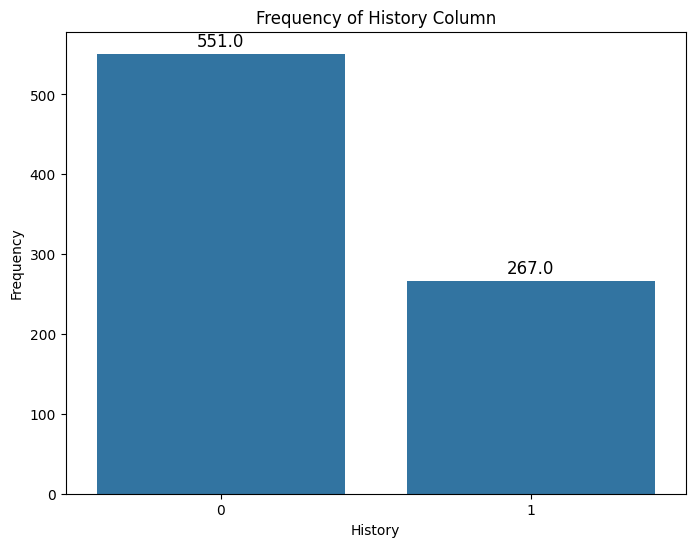

In [19]:
#Visualize the counts of history/no history

# Create a bar chart of the frequency of the history column
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='history', data=history_matches)

# Add the number of individual observations at the top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Set the labels and title
ax.set_xlabel('History')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of History Column')

# Show the plot
plt.show()

Join the weather dataset to the filtered matches dataset

In [22]:
history_wx = pd.merge(history_matches, wx, on='Fire_ID').drop(columns=['Unnamed: 0'])

history_wx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Fire_ID                 818 non-null    object 
 1   history                 818 non-null    int64  
 2   rbr                     818 non-null    float64
 3   rbr_w_offset            818 non-null    float64
 4   Fire_Year               818 non-null    int64  
 5   host_species            818 non-null    float64
 6   total_pixels            818 non-null    float64
 7   host_percentage         818 non-null    float64
 8   Average Recovery        818 non-null    float64
 9   Time_Since_Defoliation  818 non-null    int64  
 10  Cumulative_Years        818 non-null    int64  
 11  Max_Overlap_Area        818 non-null    float64
 12  Max_Overlap_Percent     818 non-null    float64
 13  fire_area               818 non-null    float64
 14  isi_90                  818 non-null    fl

In [23]:
# Write the combined DataFrame to a CSV file
history_wx.to_csv("../data/outputs/on/on_defoliation_history_wx.csv", index=False)

## investigate host %

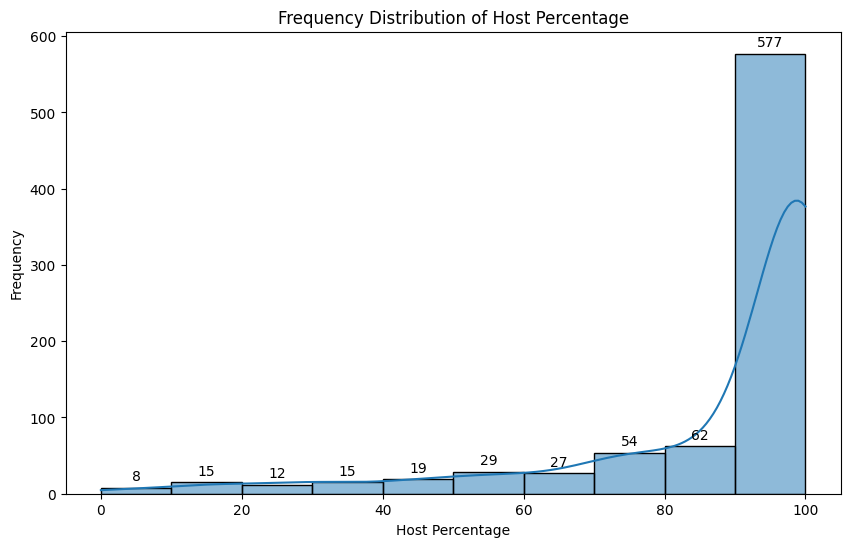

In [25]:
# Create a plot of the frequency distribution of the host_percentage column
plt.figure(figsize=(10, 6))
ax = sns.histplot(history_wx['host_percentage'], bins=10, kde=True)

# Annotate each bin with the number of fires
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  # Only annotate bins with counts
        ax.annotate(f'{int(height)}', 
                    xy=(patch.get_x() + patch.get_width() / 2, height), 
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords='offset points', 
                    ha='center', va='baseline', fontsize=10, color='black')

# Set the labels and title
plt.xlabel('Host Percentage')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Host Percentage')

# Show the plot
plt.show()

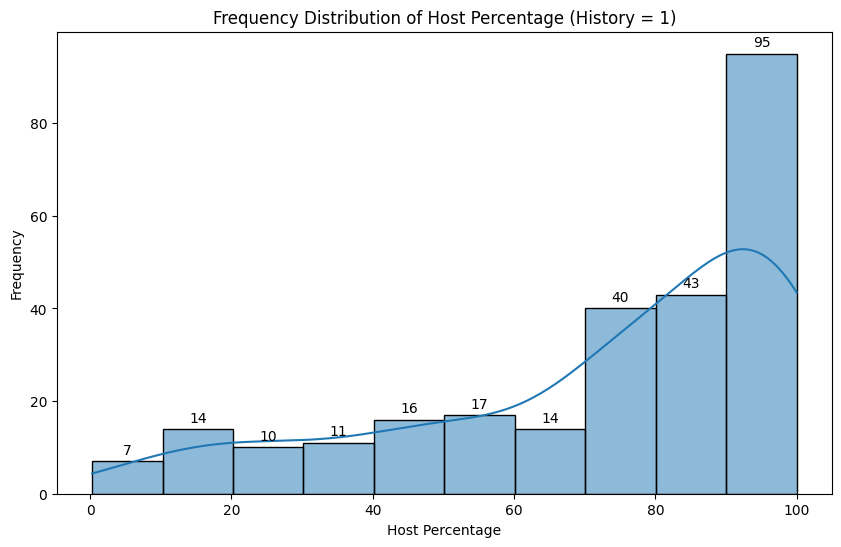

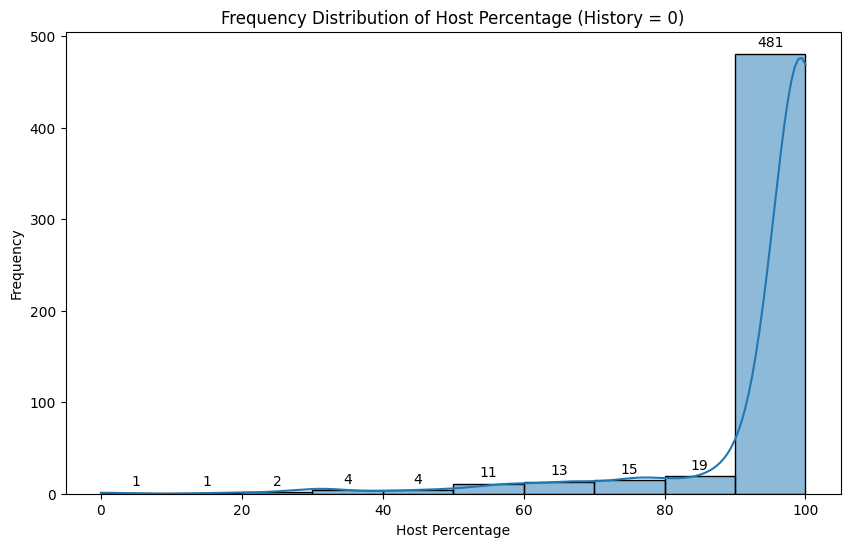

In [26]:
# Filter the DataFrame for history == 1
history_1 = history_wx[history_wx['history'] == 1]

# Filter the DataFrame for history == 0
history_0 = history_wx[history_wx['history'] == 0]

# Create a plot of the frequency distribution of the host_percentage column for history == 1
plt.figure(figsize=(10, 6))
ax1 = sns.histplot(history_1['host_percentage'], bins=10, kde=True)

# Annotate each bin with the number of fires
for patch in ax1.patches:
    height = patch.get_height()
    if height > 0:  # Only annotate bins with counts
        ax1.annotate(f'{int(height)}', 
                     xy=(patch.get_x() + patch.get_width() / 2, height), 
                     xytext=(0, 5),  # 5 points vertical offset
                     textcoords='offset points', 
                     ha='center', va='baseline', fontsize=10, color='black')

# Set the labels and title
ax1.set_xlabel('Host Percentage')
ax1.set_ylabel('Frequency')
ax1.set_title('Frequency Distribution of Host Percentage (History = 1)')

# Show the plot
plt.show()

# Create a plot of the frequency distribution of the host_percentage column for history == 0
plt.figure(figsize=(10, 6))
ax2 = sns.histplot(history_0['host_percentage'], bins=10, kde=True)

# Annotate each bin with the number of fires
for patch in ax2.patches:
    height = patch.get_height()
    if height > 0:  # Only annotate bins with counts
        ax2.annotate(f'{int(height)}', 
                     xy=(patch.get_x() + patch.get_width() / 2, height), 
                     xytext=(0, 5),  # 5 points vertical offset
                     textcoords='offset points', 
                     ha='center', va='baseline', fontsize=10, color='black')



# Set the labels and title
ax2.set_xlabel('Host Percentage')
ax2.set_ylabel('Frequency')
ax2.set_title('Frequency Distribution of Host Percentage (History = 0)')

# Show the plot
plt.show()


Filter out fires that have a host species percentage greater than 50%

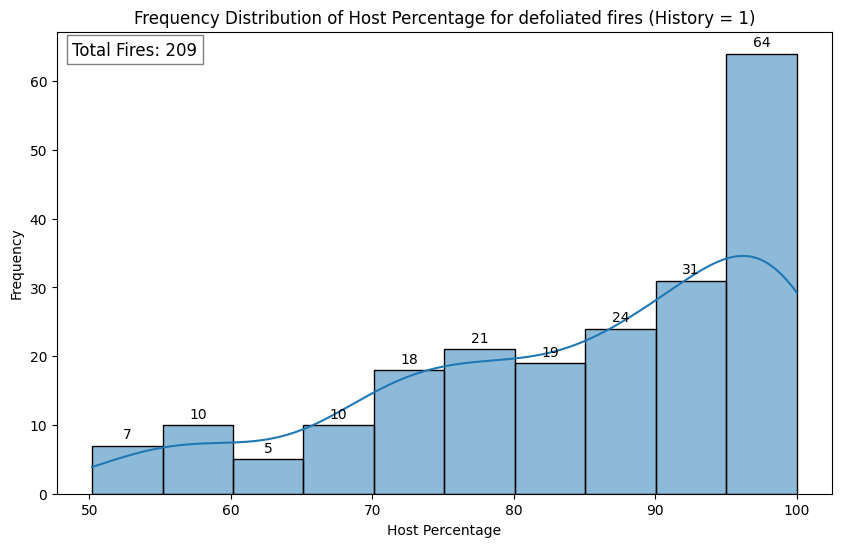

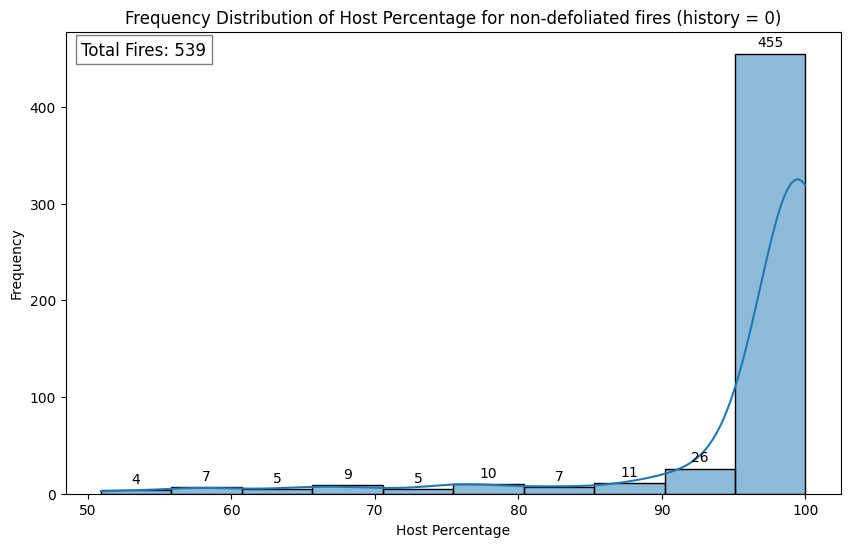

In [29]:

# Filter the DataFrame for host_percentage greater than 50%
filtered_history_wx = history_wx[history_wx['host_percentage'] > 50]

# Filter the DataFrame for history == 1
history_1 = filtered_history_wx[filtered_history_wx['history'] == 1]

# Filter the DataFrame for history == 0
history_0 = filtered_history_wx[filtered_history_wx['history'] == 0]

# Create a plot of the frequency distribution of the host_percentage column for history == 1
plt.figure(figsize=(10, 6))
ax1 = sns.histplot(history_1['host_percentage'], bins=10, kde=True)

# Annotate each bin with the number of fires
for patch in ax1.patches:
    height = patch.get_height()
    if height > 0:  # Only annotate bins with counts
        ax1.annotate(f'{int(height)}', 
                     xy=(patch.get_x() + patch.get_width() / 2, height), 
                     xytext=(0, 5),  # 5 points vertical offset
                     textcoords='offset points', 
                     ha='center', va='baseline', fontsize=10, color='black')

# Add the total number of fires in the top left corner
total_fires_1 = len(history_1)
ax1.text(0.02, 0.98, f'Total Fires: {total_fires_1}', transform=ax1.transAxes, 
         ha='left', va='top', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))

# Set the labels and title
ax1.set_xlabel('Host Percentage')
ax1.set_ylabel('Frequency')
ax1.set_title('Frequency Distribution of Host Percentage for defoliated fires (History = 1)')

# Show the plot
plt.show()

# Create a plot of the frequency distribution of the host_percentage column for history == 0
plt.figure(figsize=(10, 6))
ax2 = sns.histplot(history_0['host_percentage'], bins=10, kde=True)

# Annotate each bin with the number of fires
for patch in ax2.patches:
    height = patch.get_height()
    if height > 0:  # Only annotate bins with counts
        ax2.annotate(f'{int(height)}', 
                     xy=(patch.get_x() + patch.get_width() / 2, height), 
                     xytext=(0, 5),  # 5 points vertical offset
                     textcoords='offset points', 
                     ha='center', va='baseline', fontsize=10, color='black')

# Add the total number of fires in the top left corner
total_fires_0 = len(history_0)
ax2.text(0.02, 0.98, f'Total Fires: {total_fires_0}', transform=ax2.transAxes, 
         ha='left', va='top', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))

# Set the labels and title
ax2.set_xlabel('Host Percentage')
ax2.set_ylabel('Frequency')
ax2.set_title('Frequency Distribution of Host Percentage for non-defoliated fires (history = 0)')

# Show the plot
plt.show()

Save 50 % dataframe



In [30]:
# write filtered history dataframe to csv
filtered_history_wx.to_csv("../data/outputs/on/on_defoliation_history_wx_host_gt50.csv", index=False)

Get centroids and join

In [33]:
gdf = gpd.read_file("/home/goldma34/fire_insect_co-occurence/data/inputs/on/fire/ON_FirePerimeters_85to2020_v00.shp")


# Calculate centroids
gdf['centroid'] = gdf.geometry.centroid

# Extract x and y coordinates of the centroids
gdf['x'] = gdf['centroid'].x
gdf['y'] = gdf['centroid'].y

# Select the Fire_ID, centroid_x, and centroid_y columns
result = gdf[['Fire_ID', 'x', 'y']]

# Print the resulting DataFrame
print(result)

              Fire_ID          x          y
0        NIP53_2001_1 -87.213095  52.847048
1        NIP39_2001_2 -88.444278  52.805342
2        NIP52_2001_3 -87.507748  52.530583
3        NIP40_2001_4 -87.418806  52.301075
4        NIP35_2001_5 -87.818331  51.560622
...               ...        ...        ...
1617  SLK48_2020_2214 -90.743241  53.805535
1618  COC12_2020_2215 -89.225996  54.393503
1619   RED9_2020_2216 -94.850473  51.613156
1620  SLK47_2020_2217 -91.430288  53.924535
1621  RED30_2020_2218 -94.324531  52.699575

[1622 rows x 3 columns]


/tmp/ipykernel_3394587/3581074459.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


In [34]:
xy_history_wx = pd.merge(filtered_history_wx, result, on='Fire_ID')

Save out both files

In [35]:
xy_history_wx.to_csv("../data/outputs/on/on_defoliation_history_wx_host_gt50_xy.csv", index=False)
result.to_csv("../data/outputs/on/on_fire_centroids.csv", index=False)